# IVUS Challenge

In this notebook we will investigate whether we need more data to feed into our model.

In [1]:
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.path import Path
import numpy as np
import cv2
import random
import os
import keras
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import jaccard_score, classification_report, confusion_matrix
from skimage.metrics import hausdorff_distance
from skimage.measure import block_reduce


version = 5
seed = 123

2022-01-21 14:11:27.739378: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11226671660026665301
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5065474048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11481199648611654641
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


2022-01-21 14:11:29.516078: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-21 14:11:29.521586: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-21 14:11:29.585878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 14:11:29.586006: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 with Max-Q Design computeCapability: 6.1
coreClock: 1.48GHz coreCount: 10 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 178

## Prepare the data

### Read the images
The images are stored in the <i>Training_Set</i> folder. We will load the images from <i>Data_set_A</i>:

An empirical number of five temporally adjacent frames around the frame $F$ (two before and two after) have been included. It has been considered when more than two frames forward (and backward) in time are considered, consecutive IVUS frames might not be aligned. 

-  A training set: A subset (one fourth) of images from each dataset containing both images and manual annotations. The training set is meant for training and tuning of the algorithms prior to the evaluation. This dataset is distributed upon request for algorithm evaluation.
- A test set: The remaining frames compose the set of images that are used for performance evaluation. The annotations are not available before the algorithm evaluation in order to assure the complete blindness and equity of the algorithm assessment.

Annotations on the image datasets have been provided by four clinical experts, daily working with the specific IVUS echograph brand, and belonging to distinct medical centers. The annotation consists in the delineation of both inner wall (lumen contours) and outer wall (media/adventitia contours) on the IVUS images in the short-axis view. In all the cases, the experts were blinded to the other physicians’ annotations, and two of them repeated the manual annotations after about one week from the first labeling.


In [3]:
# Helper functions
def read_labels(directory, verbose=1):
    """
    Reads the labels from a given directory
    
    returns:
        A dictionary containing:
            'lum': array of labels of 2D coordinates
            'med': array of labels of 2D coordinates
    """
    labels_lum = []
    labels_med = []

    for file_name in sorted(os.listdir(directory)):
        points = []
        with open(os.path.join(directory, file_name)) as f:
            for line in f:
                c0, c1 = line.split(',')
                points.append((float(c0), float(c1)))

        if file_name.startswith("lum"):
            labels_lum.append(points)
        elif file_name.startswith("med"):
            labels_med.append(points)
    
    # We will have imbalances since the number of coordinates is not fixed
    # To use numpy array, we will extend every list of labels repeating the last element
    labels_lum = np.array(labels_lum, dtype=object)
    if type(labels_lum[0]) == list: # The dataset has no fixed number of rows or cols
        m = max([len(labels_lum[i]) for i in range(len(labels_lum))])
        for i in range(len(labels_lum)):
            labels_lum[i] = np.concatenate(
                (labels_lum[i], np.repeat([labels_lum[i][-1]],m-len(labels_lum[i]), axis=0))
            )
    
    labels_med = np.array(labels_med, dtype=object)
    if type(labels_med[0]) == list: # The dataset has no fixed number of rows or cols
        m = max([len(labels_med[i]) for i in range(len(labels_med))])
        for i in range(len(labels_med)):
            labels_med[i] = np.concatenate(
                (labels_med[i], np.repeat([labels_med[i][-1]],m-len(labels_med[i]), axis=0))
            )

    # We have np.arrays inside np.arrays, we have to undo this
    labels = {
        'lum': np.array([l.tolist() for l in labels_lum]),
        'med': np.array([l.tolist() for l in labels_med])
    }

    if verbose:
        print(f"Annotation for the inner wall (lumen contours): {labels['lum'].shape}")
        print(f"Annotation for the outer wall (media/adventitia contours): {labels['med'].shape}")
        
    return labels

def read_training_dataset(letter="A", verbose=1):
    """
    Reads the training dataset A or B
    
    returns:
        Two tuples (x_train, y_train_label), (x_test, y_test_label):
            x_train: dataset of images for training
            y_train_label: a dictionary containing:
                'lum': array of labels of 2D coordinates
                'med': array of labels of 2D coordinates
            x_test: dataset of images for testing
            y_test_label: a list of 3 dictionaries containing:
                'lum': array of labels of 2D coordinates
                'med': array of labels of 2D coordinates
    """
    path = os.path.join(os.getcwd(), "Training_Set", "Data_set_"+letter, "DCM")

    dataset = []
    subset = []

    count = 0
    for file_name in sorted(os.listdir(path)):
        count += 1
        subset.append(cv2.imread(os.path.join(path, file_name), cv2.IMREAD_GRAYSCALE))

        if count >= 5:
            dataset.append(subset)
            subset = []
            count = 0

    dataset = np.array(dataset)
    
    if verbose:
        print(f"Dataset {letter} has shape: {dataset.shape}")
    
    # Read the labels
    y_train_labels = []
    y_train_directory = os.path.join(os.getcwd(), "Training_Set", "Data_set_"+letter, "LABELS")
    for dir_name in ['LABELS_obs1', 'LABELS_obs2_v1', 'LABELS_obs2_v2']:
        directory = os.path.join(y_train_directory, dir_name)
        y_train_labels.append(read_labels(directory, verbose))
    
    num_training_labels = y_train_labels[0]['lum'].shape[0]
    x_train = dataset[:num_training_labels, :, :, :]
    
    x_test = dataset[num_training_labels:, :, :, :]
    
    # Read test labels
    y_test_labels = []
    y_test_directory = os.path.join(os.getcwd(), "Test_Set", "Data_set_"+letter)
    for dir_name in ['LABELS_obs1', 'LABELS_obs2_v1', 'LABELS_obs2_v2']:
        directory = os.path.join(y_test_directory, dir_name)
        y_test_labels.append(read_labels(directory, verbose))
    
    return (x_train, y_train_labels), (x_test, y_test_labels)

In [4]:
(x_train, y_train_labels), (x_test, y_test_labels) = read_training_dataset("B")

Dataset B has shape: (435, 5, 384, 384)
Annotation for the inner wall (lumen contours): (109, 360, 2)
Annotation for the outer wall (media/adventitia contours): (109, 360, 2)
Annotation for the inner wall (lumen contours): (109, 471, 2)
Annotation for the outer wall (media/adventitia contours): (109, 568, 2)
Annotation for the inner wall (lumen contours): (109, 482, 2)
Annotation for the outer wall (media/adventitia contours): (109, 574, 2)
Annotation for the inner wall (lumen contours): (326, 360, 2)
Annotation for the outer wall (media/adventitia contours): (326, 360, 2)
Annotation for the inner wall (lumen contours): (326, 581, 2)
Annotation for the outer wall (media/adventitia contours): (326, 719, 2)
Annotation for the inner wall (lumen contours): (326, 583, 2)
Annotation for the outer wall (media/adventitia contours): (326, 720, 2)


#### Downsample images for better training
Now we will downsample our training and test dataset in order to be more memory-efficient when training. We must note that when we downsample by a half our images (from 384x384 to 192x192 in dataset B), then we need to divide by 2 our contour coordinates as well.

In [5]:
def downsample_image(image):
    """Downsample image by half by applying mean pooling"""
    return block_reduce(image, block_size=(2,2), func=np.mean)

In [6]:
x_train_ds = []
for batch in x_train:
    x_train_ds.append([downsample_image(image) for image in batch])

x_train_ds = np.array(x_train_ds)
y_train_label_ds = []
for label in y_train_labels:
    y_train_label_ds.append({
        'lum': label['lum']/2.,
        'med': label['med']/2.
    })

x_test_ds = []
for batch in x_test:
    x_test_ds.append([downsample_image(image) for image in batch])

x_test_ds = np.array(x_test_ds)
y_test_label_ds = []
for label in y_test_labels:
    y_test_label_ds.append({
        'lum': label['lum']/2.,
        'med': label['med']/2.
    })

print(f"Training set now has shape {x_train_ds.shape}")
print(f"Test set now has shape {x_test_ds.shape}")

Training set now has shape (109, 5, 192, 192)
Test set now has shape (326, 5, 192, 192)


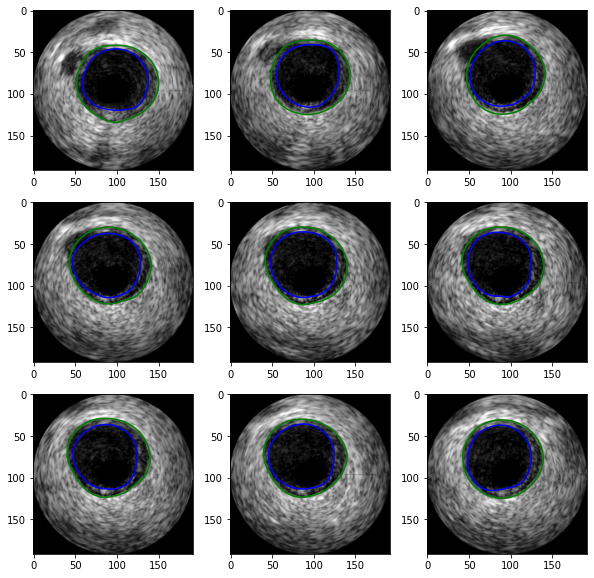

In [7]:
# Display some images
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.plot(y_train_label_ds[0]['lum'][i][:, 0], y_train_label_ds[0]['lum'][i][:, 1], 'b-')
    plt.plot(y_train_label_ds[0]['med'][i][:, 0], y_train_label_ds[0]['med'][i][:, 1], 'g-')
    plt.imshow(x_train_ds[i][2], cmap='gray')

### Create a set of mask images
We will use the labels we have to mask the interior of the paths they draw. Since we have three different classes: background, media and lumen; we will create a multiclass segmentation.

In [8]:
num_observers = len(y_train_label_ds)
num_classes = 3
CLASSES = ['background', 'media', 'lumen']

In [9]:
def create_masks(x, y):
    """
    Create masks from a dataset and its labels
    
    parameters:
        x: dataset of images
        y: array of labels of 2D coordinates
    returns:
        An array containing multiclass images segmented as follows:
            - Value 0 represents background
            - Value 1 represents the media
            - Value 2 represents the lumen
    """
    
    masks = []

    for i in range(y['lum'].shape[0]):
        # Retrieve path from the label
        path_lum = Path(y['lum'][i])
        path_med = Path(y['med'][i])
        img = x[i][2]

        # Create a matrix of coordinates to check which points are inside the closed path
        img_meshgrid = np.array(np.meshgrid(*(np.arange(s) for s in img.shape[:2]), indexing='xy'))
        img_coordinates = img_meshgrid.transpose([1,2,0]).reshape(img.shape[0]*img.shape[1],2)
        mask_lum = path_lum.contains_points(img_coordinates).reshape(img.shape[0],img.shape[1])
        mask_med = path_med.contains_points(img_coordinates).reshape(img.shape[0],img.shape[1])

        final_mask = mask_lum.astype(int) + mask_med.astype(int)
        
        masks.append(final_mask)
        
    return np.array(masks)

def get_one_hot(targets, nb_classes):
    """Returns the targets as one-hot encoded"""
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

### One-hot encoding
We one-hot encode our labels in the following way:
- Background pixels: [1, 0, 0]
- Media pixels: [0, 1, 0]
- Lumen pixels: [0, 0, 1]

This encoding will help optimize our model because we plan to output the probability of each pixel belonging to a certain class.

In [10]:
masks = np.concatenate(
    [create_masks(x_train_ds, observer_labels) for observer_labels in y_train_label_ds]
)
    
y_train_ds = get_one_hot(masks, num_classes)
x_train_ds = np.concatenate([x_train_ds for _ in range(num_observers)])

In [11]:
# GET TEST IMAGES
masks = np.concatenate(
    [create_masks(x_train_ds, observer_labels) for observer_labels in y_test_label_ds]
)
    
y_test_ds = get_one_hot(masks, num_classes)
x_test_ds = np.concatenate([x_test_ds for _ in range(num_observers)])

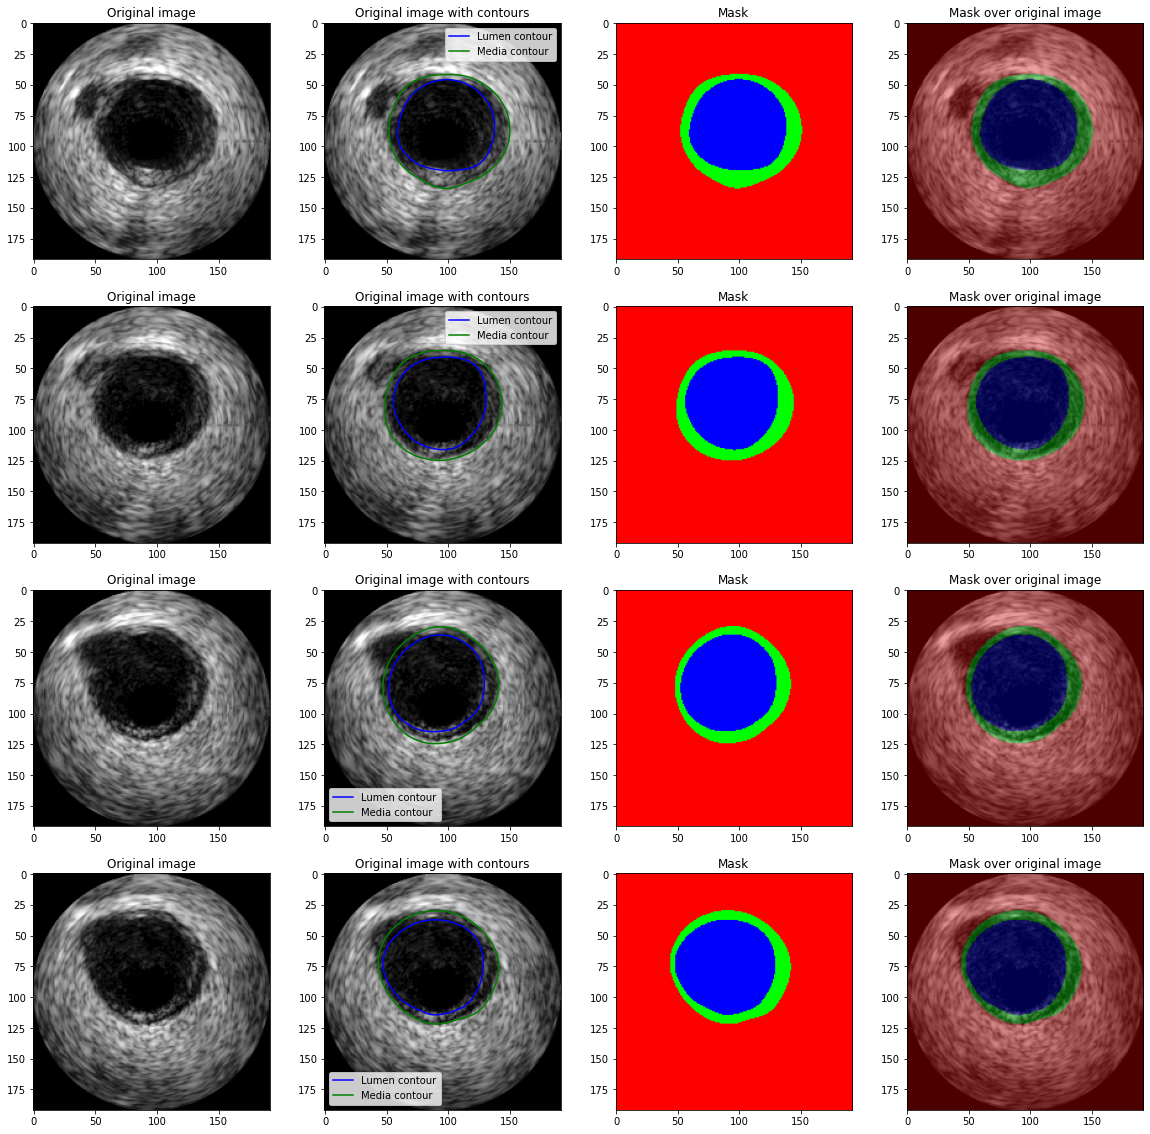

In [12]:
# Let's show some examples
plt.figure(figsize=(20, 20))

samples = 4

for i in range(samples):
    
    
    ax = plt.subplot(samples, 4, 4*i + 1)
    plt.imshow(x_train_ds[i][2], cmap='gray')
    plt.title('Original image')
    
    ax = plt.subplot(samples, 4, 4*i + 2)
    plt.plot(y_train_label_ds[0]['lum'][i][:, 0], y_train_label_ds[0]['lum'][i][:, 1], 'b-', label='Lumen contour')
    plt.plot(y_train_label_ds[0]['med'][i][:, 0], y_train_label_ds[0]['med'][i][:, 1], 'g-', label='Media contour')
    plt.imshow(x_train_ds[i][2], cmap='gray')
    plt.title('Original image with contours')
    plt.legend()
    
    
    mask = y_train_ds[i]/y_train_ds.max()
    ax = plt.subplot(samples, 4, 4*i + 3)
    plt.imshow(mask)
    plt.title('Mask')
    
    
    image = np.repeat(x_train_ds[i][2][..., np.newaxis], 3, axis=2)
    alpha = 0.7
    ax = plt.subplot(samples, 4, 4*i + 4)
    plt.imshow(np.uint8(image*alpha + mask*255*(1-alpha)))
    plt.title('Mask over original image')

### Data augmentation
We have 19 images to train using dataset A and 109 images in dataset B. Therefore we should apply Data Augmentation in order to get more training examples to feed into our model.

In this test we will only use the images adjacent to the middle image and we will pass these 3 images as 3 channels RGB to the data generator.

In [13]:
images = x_train_ds[:, 2:5, :, :].transpose([0, 2, 3, 1])/255 # Now the shape is (109, 192, 192, 3) (for dataset B)
masks = np.copy(y_train_ds) # Now the shape is (109, 384, 384, channels) (for dataset B)

print(f"Shape of set images: {images.shape}")
print(f"Shape of set masks: {masks.shape}")


input_shape = images.shape[1:] # (192, 192, 3)

Shape of set images: (327, 192, 192, 3)
Shape of set masks: (327, 192, 192, 3)


In [14]:
images_test = x_test_ds[:, 2:5, :, :].transpose([0, 2, 3, 1])/255 # Now the shape is (num_images, 192, 192, 3) (for dataset B)
masks_test = np.copy(y_test_ds) # Now the shape is (num_images, 192, 192, channels) (for dataset B)

    
print(f"Shape of set images_test: {images_test.shape}")
print(f"Shape of set masks_test: {masks_test.shape}")

Shape of set images_test: (978, 192, 192, 3)
Shape of set masks_test: (978, 192, 192, 3)


In [15]:
batch_size = 20

def get_image_generator(data_gen_args=dict(data_format="channels_last", validation_split=0.15),
                        images=images,
                        masks=masks,
                        batch_size=batch_size):
    # we create two instances with the same arguments
    val_data_gen_args = dict(
        data_format=data_gen_args['data_format'],
        validation_split=data_gen_args['validation_split']
    )

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    val_datagen = ImageDataGenerator(**val_data_gen_args)

    image_datagen.fit(images, augment=True, seed=seed)
    mask_datagen.fit(masks, augment=True, seed=seed)

    # Provide the same seed and keyword arguments to the fit and flow methods
    image_generator = image_datagen.flow(images, seed=seed, batch_size=batch_size, subset='training')
    mask_generator = mask_datagen.flow(masks, seed=seed, batch_size=batch_size, subset='training')

    image_val_generator = val_datagen.flow(images, seed=seed, batch_size=batch_size, subset='validation')
    mask_val_generator = val_datagen.flow(masks, seed=seed, batch_size=batch_size, subset='validation')

    # combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)
    val_generator = zip(image_val_generator, mask_val_generator)
    
    return train_generator, val_generator

def gen_dtype(gen):
    while True:
        for i,j in gen:
            yield (i.astype('float32'), j.astype('float32'))

#def gen_dtype_test(gen):
#    for i,j in gen:
#        yield (i.astype('float32'), to_categorical(j.astype('int'), num_classes=num_classes))

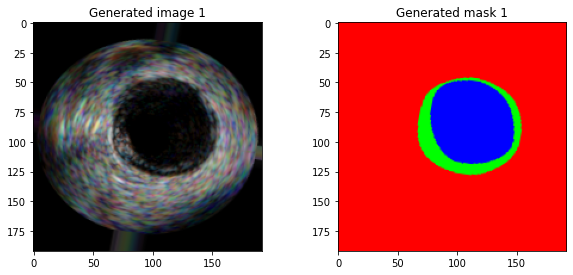

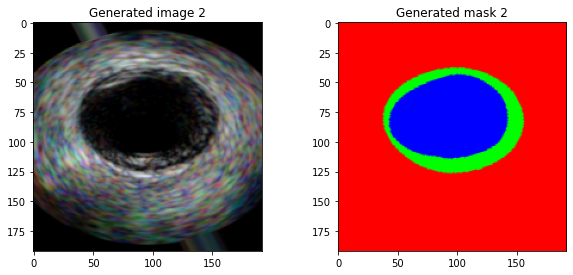

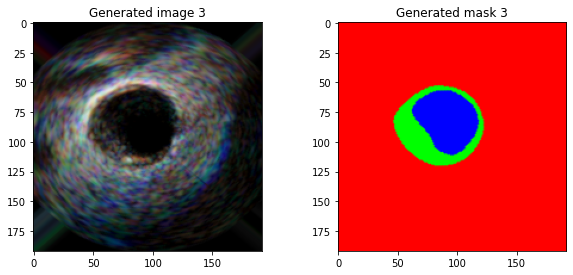

In [16]:
# Let's show some example
data_gen_args = dict(
    rotation_range=90,
    zoom_range=0.2,
    data_format="channels_last",
    validation_split=0.15
)
train_generator, val_generator = get_image_generator(data_gen_args)
images_gen, masks_gen = next(gen_dtype(train_generator))
samples = len(images_gen)

for i in range(3):
    plt.figure(figsize=(10,100))
    plt.subplot(samples, 2, 2*i+1)
    plt.imshow(images_gen[i], cmap='gray')
    plt.title(f"Generated image {i+1}")
    
    plt.subplot(samples, 2, 2*i+2)
    plt.imshow(masks_gen[i])
    plt.title(f"Generated mask {i+1}")

### Elastic deformations
Elastic_transform as suggested by the authors of the original U-Net article as a mean for data augmentation : https://arxiv.org/abs/1505.04597

Source: https://www.kaggle.com/ori226/data-augmentation-with-elastic-deformations

In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage.io
from skimage import color
from skimage import io
import glob
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

In [18]:
#taken from: https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation
# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

# Define function to draw a grid
def draw_grid(im, grid_size):
    for channel in range(im.shape[2]):
        # Draw grid lines
        for i in range(0, im.shape[1], grid_size):
            cv2.line(im[:, :, channel], (i, 0), (i, im.shape[0]), color=(1,))
        for j in range(0, im.shape[0], grid_size):
            cv2.line(im[:, :, channel], (0, j), (im.shape[1], j), color=(1,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


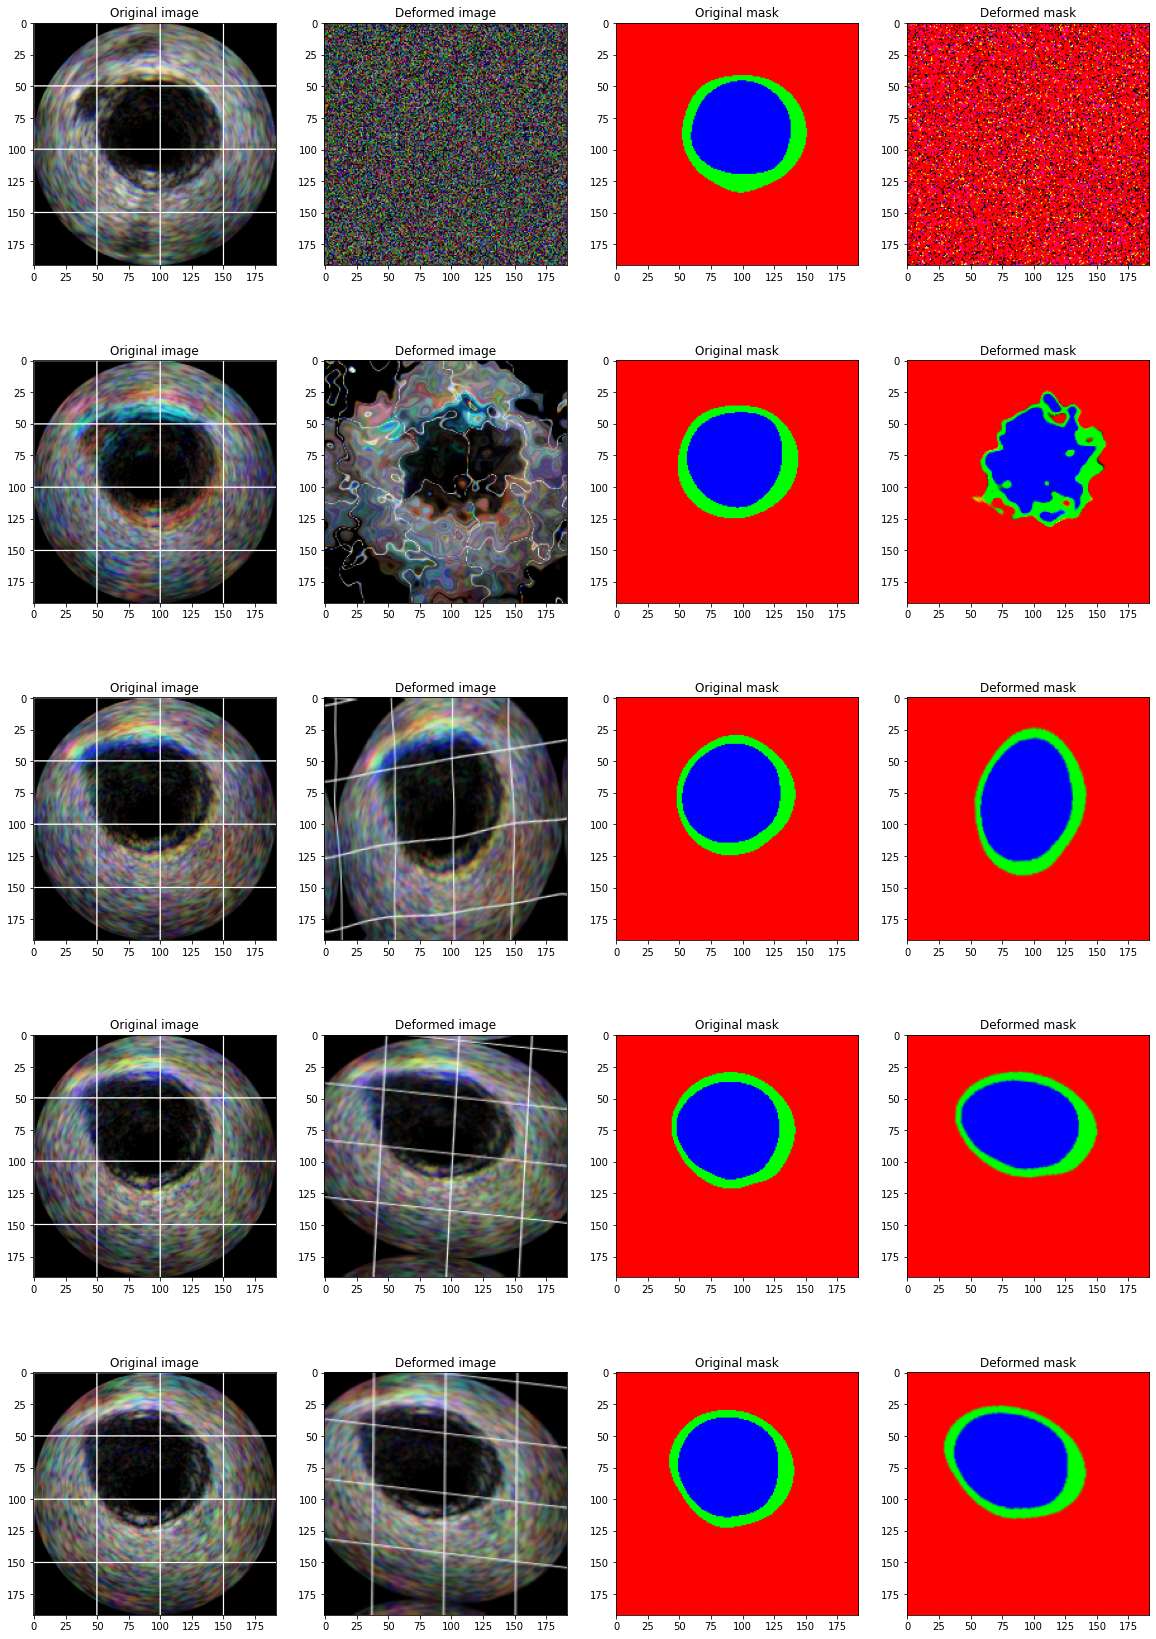

In [19]:
samples = 5

imgs = np.copy(images[:samples])
msks = np.copy(masks[:samples])

plt.figure(figsize=(20,30))
b = [0.001, 0.02, 0.1, 0.4, 2]
random_state = np.random.RandomState(seed=seed)
for i in range(len(imgs)):
    draw_grid(imgs[i], 50)
    img = np.concatenate((imgs[i],msks[i]), axis=-1)
    im = elastic_transform(img, img.shape[1] * 2, img.shape[1] * b[i], img.shape[1] * 0.08)
    
    original_image = img[:, :, :3]
    original_mask = img[:, :, 3:]
    generated_image = im[:, :, :3]
    generated_mask = im[:, :, 3:]
    
    plt.subplot(samples, 4, 4*i+1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f"Original image")
    
    plt.subplot(samples, 4, 4*i+2)
    plt.imshow(generated_image, cmap='gray')
    plt.title(f"Deformed image")
    
    
    plt.subplot(samples, 4, 4*i+3)
    plt.imshow(original_mask)
    plt.title(f"Original mask")
    
    plt.subplot(samples, 4, 4*i+4)
    plt.imshow(generated_mask)
    plt.title(f"Deformed mask")
    

In [20]:
# Here, `x_set` is list of images
# and `y_set` is the list of associated masks.      

class ElasticDataGen(tf.keras.utils.Sequence):    
    def __init__(self, x_set, y_set, batch_size, a=2, b=0.1, c=0.08, apply_deformation=True):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.a = a
        self.b = b
        self.c = c
        self.apply_deformation = apply_deformation

    def __len__(self):
        return int(np.floor(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        idx1 = idx * self.batch_size
        idx2 = (idx+1) * self.batch_size
        
        batch_x = self.x[idx1:idx2]
        batch_y = self.y[idx1:idx2]
        
        if not self.apply_deformation:
            return np.array(batch_x), np.array(batch_y)

        X = []
        Y = []
        for x, y in zip(batch_x, batch_y):
            img = np.concatenate((x, y), axis=-1)
            img_transformed = self.elastic_transform(
                img,
                img.shape[1] * self.a,
                img.shape[1] * self.b,
                img.shape[1] * self.c
            )
            X.append(img_transformed[:, :, :3])
            Y.append(img_transformed[:, :, 3:])
        
        return np.array(X), np.array(Y)
    
    #taken from: https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation
    # Function to distort image
    def elastic_transform(self, image, alpha, sigma, alpha_affine, random_state=None):
        """Elastic deformation of images as described in [Simard2003]_ (with modifications).
        .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
             Convolutional Neural Networks applied to Visual Document Analysis", in
             Proc. of the International Conference on Document Analysis and
             Recognition, 2003.

         Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
        """
        if random_state is None:
            random_state = np.random.RandomState(None)

        shape = image.shape
        shape_size = shape[:2]

        # Random affine
        center_square = np.float32(shape_size) // 2
        square_size = min(shape_size) // 3
        pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
        pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
        M = cv2.getAffineTransform(pts1, pts2)
        image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
        dz = np.zeros_like(dx)

        x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
        indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

        return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


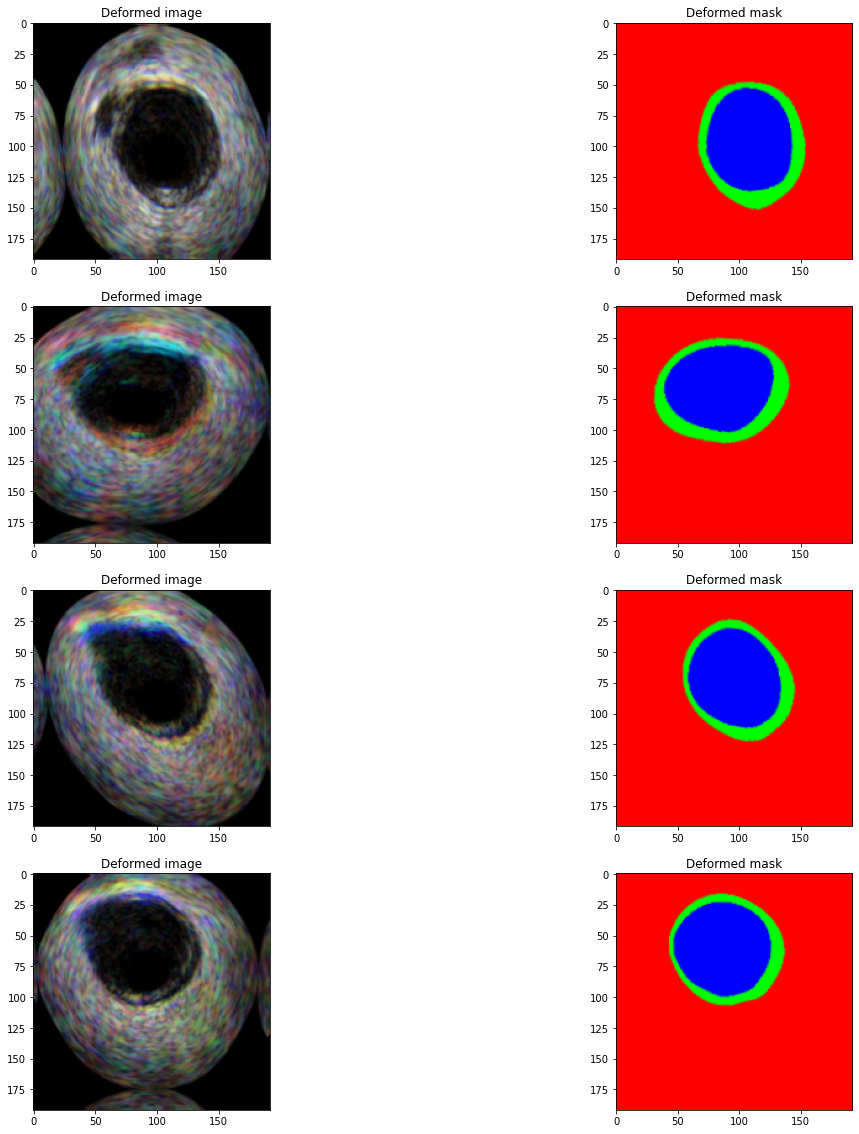

In [21]:
gen = ElasticDataGen(images, masks, batch_size=batch_size, a=2, b=0.1, c=0.08, apply_deformation=True)

plt.figure(figsize=(20,20))
for batch_x, batch_y in gen:
    
    samples = 4
    
    for i in range(samples):

        plt.subplot(samples, 4, 4*i+2)
        plt.imshow(batch_x[i], cmap='gray')
        plt.title(f"Deformed image")

        plt.subplot(samples, 4, 4*i+4)
        plt.imshow(batch_y[i])
        plt.title(f"Deformed mask")

    break

## Transfer Learning with U-Net Inception (best performance)

### InceptionResNetV2

In [22]:
from Semantic_Segmentation_Architecture.TensorFlow.inception_resnetv2_unet import build_inception_resnetv2_unet
tf.keras.backend.clear_session()
inception_model = build_inception_resnetv2_unet(input_shape)
inception_model.summary()

2022-01-21 14:13:33.566674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 14:13:33.566842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 with Max-Q Design computeCapability: 6.1
coreClock: 1.48GHz coreCount: 10 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 178.99GiB/s
2022-01-21 14:13:33.566939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 14:13:33.567067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-21 14:13:33.567153: I tens

Model: "InceptionResNetV2_U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 95, 95, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 95, 95, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 95, 95, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(inception_model,to_file='inception_struct.png',show_shapes=True, show_layer_names=True)

Display layers status (trainable or non-trainable)

In [ ]:
inception_layers = [(layer, layer.name, layer.trainable) for layer in inception_model.layers]
inception_model_df = pd.DataFrame(inception_layers, columns=["Layer Type", "Layer Name", "Layer Trainable"])

display(inception_model_df)

## Training the transfer learning U-Net model
We will use different pacients for each fold, therefore we need to concatenate all images and separate them by pacient

In [23]:
X = np.array([np.concatenate(x, axis=0) for x in zip(np.split(images, 3), np.split(images_test, 3))])
Y = np.array([np.concatenate(x, axis=0) for x in zip(np.split(masks, 3), np.split(masks_test, 3))])

In [24]:
num_images_by_pacient = [50, 50, 30, 50, 50, 50, 50, 25, 50, 30]

acc = 0
images_by_pacient = []
masks_by_pacient = []
for n in num_images_by_pacient:
    images_by_pacient.append(np.concatenate(X[:, acc:acc+n, :, :, :], axis=0))
    masks_by_pacient.append(np.concatenate(Y[:, acc:acc+n, :, :, :], axis=0))
    acc += n

In [25]:
# More helper functions

def get_mask_from_prediction(prediction):
    return np.rint(prediction)

def get_class_mask_from_prediction(prediction):
    return np.argmax(prediction, axis=-1)

def print_predictions(image, ground_truth, prediction, save_filename=None):
    plt.figure(figsize=(20,20))
    plt.subplot(1, 3, 1)
    plt.title("Original image")
    plt.axis('off')
    plt.imshow(image)
    
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.axis('off')
    plt.imshow(ground_truth)
    
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.axis('off')
    plt.imshow(prediction) 
    
    if save_filename:
        plt.savefig(os.path.join(os.getcwd(), "output", f"v{version}", "masks_prediction", save_filename))

def print_predictions_overlay(image, ground_truth, prediction, save_filename=None):
    plt.figure(figsize=(20,20))
    plt.subplot(1, 3, 1)
    plt.title("Original image")
    plt.axis('off')
    plt.imshow(image)
    
    handles = [
        mpatches.Patch(color='red', label='Ground Truth & Not Predicted'),
        mpatches.Patch(color='xkcd:green', label='Not Ground Truth & Predicted'),
        mpatches.Patch(color='blue', label='Ground Truth & Predicted')
    ]
    
    media_image = np.zeros(image.shape)
    media_image[:, :, 0][(ground_truth[:, :, 1]==1) & (prediction[:, :, 1]==0)] = 1
    media_image[:, :, 1][(ground_truth[:, :, 1]==0) & (prediction[:, :, 1]==1)] = 1
    media_image[:, :, 2][(ground_truth[:, :, 1]==1) & (prediction[:, :, 1]==1)] = 1
    plt.subplot(1, 3, 2)
    plt.title("Media mask")
    plt.axis('off')
    plt.legend(handles=handles)
    plt.imshow(media_image)
    
    lumen_image = np.zeros(image.shape)
    lumen_image[:, :, 0][(ground_truth[:, :, 2]==1) & (prediction[:, :, 2]==0)] = 1
    lumen_image[:, :, 1][(ground_truth[:, :, 2]==0) & (prediction[:, :, 2]==1)] = 1
    lumen_image[:, :, 2][(ground_truth[:, :, 2]==1) & (prediction[:, :, 2]==1)] = 1
    plt.subplot(1, 3, 3)
    plt.title("Lumen mask")
    plt.axis('off')
    plt.legend(handles=handles)
    plt.imshow(lumen_image)
    
    if save_filename:
        plt.savefig(os.path.join(os.getcwd(), "output", f"v{version}", "masks_overlay", save_filename))

Define the loss and metrics functions

In [26]:
#calculates dice considering an input with a single class
def dice_single(true, pred, smooth=1.):
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = K.round(pred)

    intersection = K.sum(true * pred, axis=-1)
    true = K.sum(true, axis=-1)
    pred = K.sum(pred, axis=-1)

    return ((2*intersection) + smooth) / (true + pred + smooth)

def dice_for_class(index, smooth=1.):
    def dice_inner(true, pred):

        #get only the desired class
        true = true[:,:,:,index]
        pred = pred[:,:,:,index]

        #return dice per class
        return dice_single(true, pred, smooth)
    dice_inner.__name__ = f'dice_{CLASSES[index]}'
    return dice_inner

def dice_coef_loss(y_true, y_pred, smooth=1.):
    """
    Dice loss to minimize: 1 - Dice
    Dice = (2*|X & Y|)/ (|X| + |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    # Ignore label 0 which belongs to background
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred, axis=-1)
    denom = K.sum(y_true + y_pred, axis=-1)
    dice = K.mean(((2. * intersection + smooth) / (denom + smooth)))
    return 1 - dice

    
def jaccard_coef_loss(y_true, y_pred, smooth=1.):
    """Jaccard distance for semantic segmentation.
    Also known as the intersection-over-union loss.
    
    source code: 
    https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/losses/jaccard.py
    
    Parameters
    -----------
    y_true : Tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    y_pred : Tensor
        The target distribution, format the same with `output`.
    smooth : float
        This small value will be added to the numerator and denominator.
            - If both output and target are empty, it makes sure dice is 1.
            - If either output or target are empty (all pixels are background),
            dice = ```smooth/(small_value + smooth)``,
            then if smooth is very small, dice close to 0 (even the image values lower than the threshold),
            so in this case, higher smooth can have a higher dice.
            
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

### K-Fold Cross Validation with the entire set using different pacients

In [27]:
# Classification metrics
def get_specificity(col, cm):
    """Return the specificity of a variable in a 3x3 confusion matrix"""
    col_bef = (col-1)%3
    col_aft = (col+1)%3
    
    tp = cm[col,col]
    tn = cm[col_bef,col_bef] + cm[col_aft,col_aft]
    fp = cm[col_bef,col] + cm[col_aft,col]
    fn = cm[col,col_bef] + cm[col,col_aft]
    
    return float(tn)/float(tn+fp)

def get_accuracy(col, cm):
    """Return the accuracy of a variable in a 3x3 confusion matrix"""
    col_bef = (col-1)%3
    col_aft = (col+1)%3
    
    tp = cm[col,col]
    tn = cm[col_bef,col_bef] + cm[col_aft,col_aft]
    fp = cm[col_bef,col] + cm[col_aft,col]
    fn = cm[col,col_bef] + cm[col,col_aft]
    
    return float(tp+tn)/float(tp+tn+fp+fn)

from sklearn.metrics import jaccard_score, classification_report, confusion_matrix
from skimage.metrics import hausdorff_distance
import pandas as pd

def custom_classification_report(y_true, y_pred, classes=['background', 'media', 'lumen']):
    
    # Obtain precision, recall, f1-score and support
    data = classification_report(
        y_true.flatten(),
        y_pred.flatten(),
        output_dict=True,
        target_names=classes
    )
    data.pop('macro avg')
    data.pop('weighted avg')
    data.pop('accuracy')
    
    # Get jaccard score
    jacc = jaccard_score(
        y_true.flatten(),
        y_pred.flatten(),
        average=None
    )
    
    # Compute hausdorff distance of every image
    hausdorff_dist_list = np.zeros((len(classes), len(y_true)))
    for i in range(len(y_true)):
        # Ground truth
        gt = y_true[i]
        # Predicted segmentation
        seg = y_pred[i]

        # Evaluate for each class
        for j in range(len(classes)):
            hausdorff_dist_list[j, i] = hausdorff_distance(gt==j, seg==j)
    hd = hausdorff_dist_list
    
    # Finally compute specificity
    cm = confusion_matrix(y_true.flatten(), y_pred.flatten())
    for i in range(len(classes)):
        data[classes[i]]['specificity'] = get_specificity(i, cm)
        data[classes[i]]['accuracy'] = get_accuracy(i, cm)
        data[classes[i]]['jaccard_score'] = jacc[i]
        data[classes[i]]['hausdorff_dist'] = hd[i]
    
    return pd.DataFrame(data)

In [28]:
from sklearn.model_selection import KFold

def get_callbacks(name_weights, patience_lr):
    mcp_save = keras.callbacks.ModelCheckpoint(
        name_weights,
        save_weights_only=True,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
    reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        factor=0.1,
        patience=patience_lr,
        verbose=1,
        min_delta=1e-4,
        mode='min'
    )
    return [mcp_save, reduce_lr_loss]

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
loss = jaccard_coef_loss
metrics = [dice_for_class(i) for i in range(num_classes)]
elastic_values = {'a': 2, 'b': 0.1, 'c': 0.08}


Fold 0. Training with pacients [0, 1]


2022-01-20 10:49:36.353889: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-20 10:49:36.376659: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2299965000 Hz
2022-01-20 10:49:42.907049: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-01-20 10:49:43.627476: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2022-01-20 10:49:44.410080: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-20 10:49:44.410116: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-01-20 10:49:44.412336: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-20 10:49:44.413067: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

29/29 [==============================] - 15s 520ms/step - loss: 0.0328 - dice_background: 0.9798 - dice_media: 0.6537 - dice_lumen: 0.8955


2022-01-20 11:29:28.078375: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 404766720 exceeds 10% of free system memory.


background  \
precision                                                0.977465   
recall                                                   0.982371   
f1-score                                                 0.979912   
support                                                  28697362   
specificity                                              0.857924   
accuracy                                                  0.96526   
jaccard_score                                            0.960615   
hausdorff_dist  [10.816653826391969, 6.324555320336759, 9.0, 6...   

                                                            media  \
precision                                                 0.65576   
recall                                                   0.664537   
f1-score                                                 0.660119   
support                                                   2245649   
specificity                                              0.975057   
accuracy                                                 0.954336   
jaccard_score                                             0.49267   
hausdorff_dist  [52.172789842982326, 48.76474136094644, 51.0, ...   

                                                            lumen  
precision                                                0.930676  
recall                                                   0.872558  
f1-score                                                 0.900681  
support                                                   2787549  
specificity                                              0.993933  
accuracy                                                 0.983572  
jaccard_score                                            0.819307  
hausdorff_dist  [8.94427190999916, 7.615773105863909, 53.0, 9....


Fold 1. Training with pacients [2, 3]


2022-01-20 11:32:33.284891: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-20 11:32:35.007423: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.85GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
/tmp/ipykernel_4487/2020776655.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f1.show()
/tmp/ipykernel_4487/2020776655.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f2.show()
/tmp/ipyke

29/29 [==============================] - 13s 438ms/step - loss: 0.0427 - dice_background: 0.9694 - dice_media: 0.6202 - dice_lumen: 0.8428


background  \
precision                                                0.945281   
recall                                                   0.995609   
f1-score                                                 0.969793   
support                                                  28362880   
specificity                                              0.676483   
accuracy                                                 0.947355   
jaccard_score                                            0.941357   
hausdorff_dist  [33.24154027718932, 34.0, 45.221676218380054, ...   

                                                            media  \
precision                                                0.792087   
recall                                                   0.513019   
f1-score                                                 0.622716   
support                                                   2336053   
specificity                                              0.989777   
accuracy                                                 0.956139   
jaccard_score                                            0.452134   
hausdorff_dist  [43.01162633521314, 24.596747752497688, 46.647...   

                                                            lumen  
precision                                                 0.94668  
recall                                                    0.73214  
f1-score                                                 0.825702  
support                                                   3031627  
specificity                                              0.995771  
accuracy                                                  0.97125  
jaccard_score                                            0.703145  
hausdorff_dist  [20.615528128088304, 15.811388300841896, 31.90...


Fold 2. Training with pacients [4, 5]


/tmp/ipykernel_4487/2020776655.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f1.show()
/tmp/ipykernel_4487/2020776655.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f2.show()
/tmp/ipykernel_4487/2020776655.py:73: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f3.show()
/tmp/ipykernel_4487/2020776655.py:83: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f4.show()


27/27 [==============================] - 14s 520ms/step - loss: 0.0241 - dice_background: 0.9869 - dice_media: 0.7265 - dice_lumen: 0.9227


background  \
precision                                                 0.97843   
recall                                                   0.995971   
f1-score                                                 0.987123   
support                                                  26473725   
specificity                                              0.874814   
accuracy                                                 0.977892   
jaccard_score                                            0.974573   
hausdorff_dist  [7.615773105863909, 19.72308292331602, 21.8403...   

                                                            media  \
precision                                                0.790649   
recall                                                   0.687256   
f1-score                                                 0.735336   
support                                                   2108183   
specificity                                              0.986935   
accuracy                                                 0.966861   
jaccard_score                                            0.581448   
hausdorff_dist  [9.848857801796104, 17.0, 21.93171219946131, 2...   

                                                            lumen  
precision                                                0.954406  
recall                                                   0.889767  
f1-score                                                 0.920953  
support                                                   2936812  
specificity                                              0.995532  
accuracy                                                 0.985473  
jaccard_score                                            0.853488  
hausdorff_dist  [7.0710678118654755, 14.212670403551895, 16.27...


Fold 3. Training with pacients [6, 7]


/tmp/ipykernel_4487/2020776655.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f1.show()
/tmp/ipykernel_4487/2020776655.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f2.show()
/tmp/ipykernel_4487/2020776655.py:73: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f3.show()
/tmp/ipykernel_4487/2020776655.py:83: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f4.show()


30/30 [==============================] - 14s 452ms/step - loss: 0.0237 - dice_background: 0.9865 - dice_media: 0.7227 - dice_lumen: 0.9212


background  \
precision                                                0.981778   
recall                                                   0.991474   
f1-score                                                 0.986602   
support                                                  29317123   
specificity                                              0.882393   
accuracy                                                 0.976716   
jaccard_score                                            0.973559   
hausdorff_dist  [4.47213595499958, 11.180339887498949, 13.0384...   

                                                            media  \
precision                                                0.780352   
recall                                                   0.688302   
f1-score                                                 0.731443   
support                                                   2186369   
specificity                                              0.986777   
accuracy                                                 0.967707   
jaccard_score                                            0.576594   
hausdorff_dist  [8.54400374531753, 12.649110640673518, 31.3847...   

                                                            lumen  
precision                                                0.925204  
recall                                                   0.914679  
f1-score                                                 0.919911  
support                                                   2780028  
specificity                                              0.993321  
accuracy                                                 0.986806  
jaccard_score                                            0.851699  
hausdorff_dist  [10.0, 13.0, 10.0, 13.341664064126334, 14.3178...


Fold 4. Training with pacients [8, 9]


/tmp/ipykernel_4487/2020776655.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f1.show()
/tmp/ipykernel_4487/2020776655.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f2.show()
/tmp/ipykernel_4487/2020776655.py:73: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f3.show()
/tmp/ipykernel_4487/2020776655.py:83: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f4.show()


29/29 [==============================] - 12s 403ms/step - loss: 0.0275 - dice_background: 0.9832 - dice_media: 0.7196 - dice_lumen: 0.9112


background  \
precision                                                0.986169   
recall                                                   0.980459   
f1-score                                                 0.983306   
support                                                  28979709   
specificity                                              0.909023   
accuracy                                                  0.97108   
jaccard_score                                             0.96716   
hausdorff_dist  [4.242640687119285, 3.605551275463989, 4.0, 4....   

                                                            media  \
precision                                                0.678609   
recall                                                   0.777306   
f1-score                                                 0.724613   
support                                                   2144268   
specificity                                              0.974954   
accuracy                                                 0.962364   
jaccard_score                                            0.568151   
hausdorff_dist  [4.242640687119285, 3.605551275463989, 3.60555...   

                                                            lumen  
precision                                                0.940062  
recall                                                   0.888103  
f1-score                                                 0.913344  
support                                                   2606583  
specificity                                              0.995117  
accuracy                                                 0.986622  
jaccard_score                                            0.840509  
hausdorff_dist  [2.8284271247461903, 3.605551275463989, 3.6055...

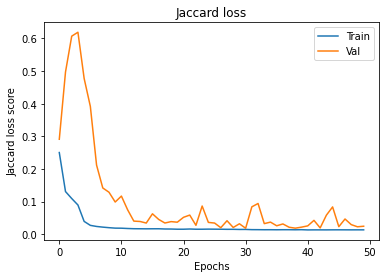

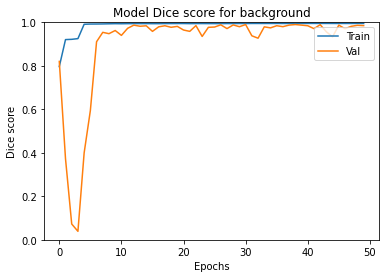

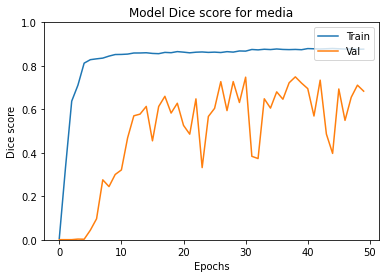

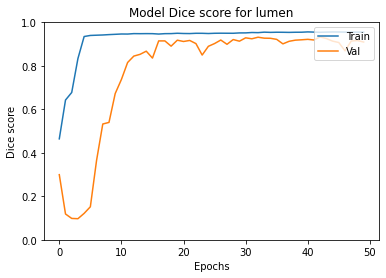

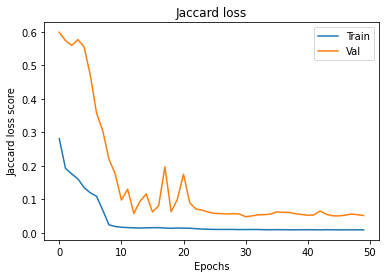

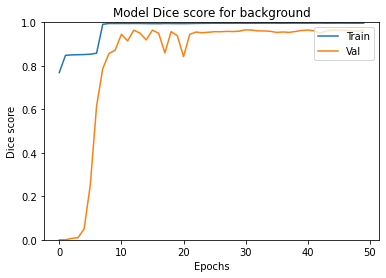

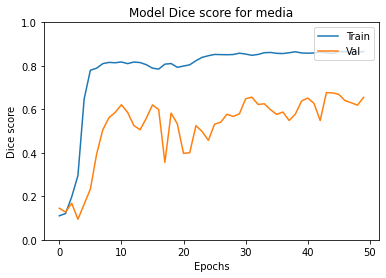

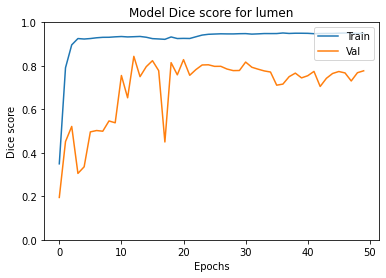

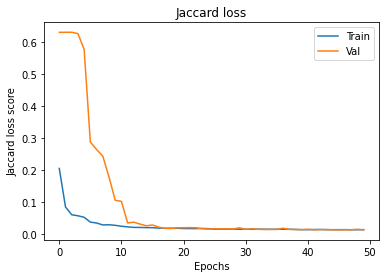

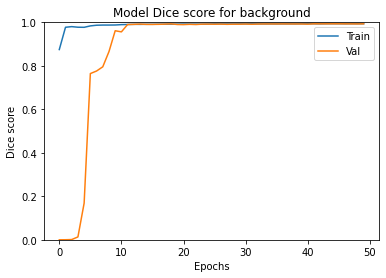

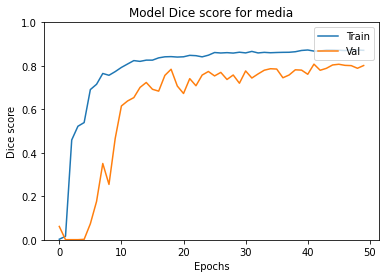

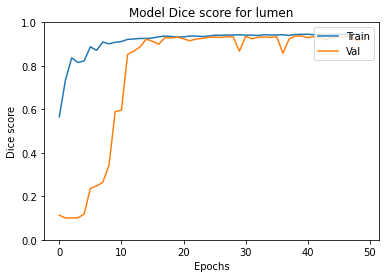

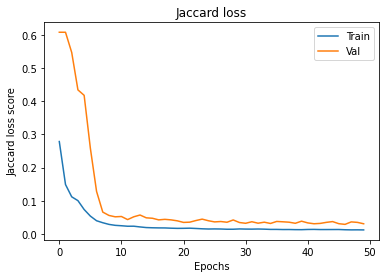

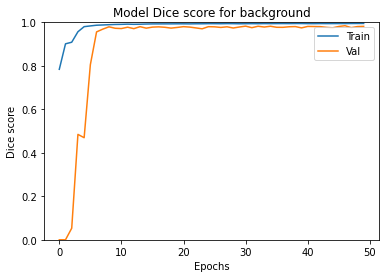

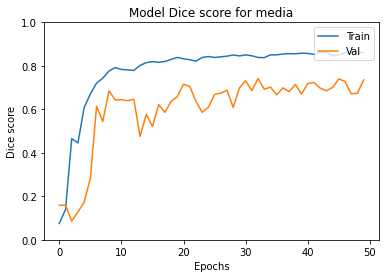

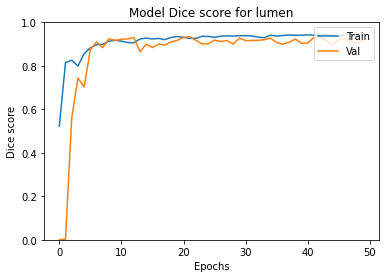

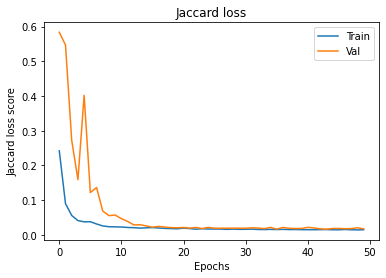

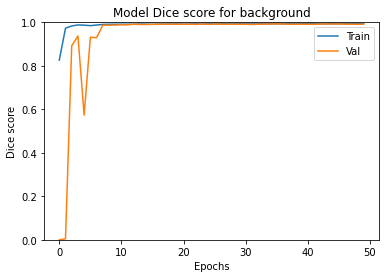

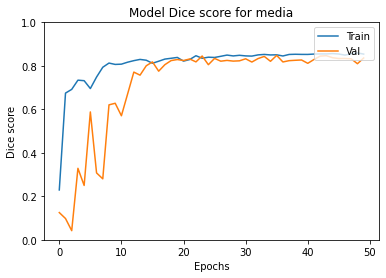

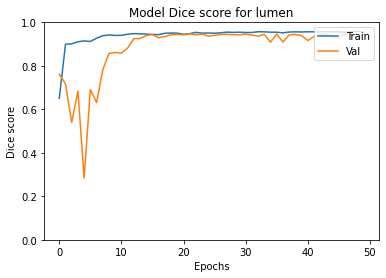

In [29]:
from tensorflow.keras import backend as K

# Prediction of all test images
def get_class_mask_from_prediction(prediction):
    return np.argmax(prediction, axis=-1)

data_by_fold = []

for i in range(5):
    train_idx = [2*i, 2*i+1]
    val_idx = 2*(i+1)%10
    test_idx = [j for j in range(len(images_by_pacient)) if j not in train_idx+[val_idx]]
    
    # Free up RAM in case the model definition cells were run multiple times
    K.clear_session()
    epochs = 50
    optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    print(f'\nFold {i}. Training with pacients {train_idx}')
    X_train_cv = np.concatenate([images_by_pacient[j] for j in train_idx], axis=0)
    y_train_cv = np.concatenate([masks_by_pacient[j] for j in train_idx], axis=0)
    X_valid_cv = images_by_pacient[val_idx]
    y_valid_cv = masks_by_pacient[val_idx]
    
    name_weights = f"modelF_fold_p{train_idx[0]}_p{train_idx[1]}"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    generator = gen_dtype(ElasticDataGen(X_train_cv, y_train_cv, batch_size=batch_size, **elastic_values))
    
    model = build_inception_resnetv2_unet(input_shape)
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    history = model.fit(
        generator,
        validation_data=(X_valid_cv, y_valid_cv),
        shuffle=True,
        steps_per_epoch=len(X_train_cv)/batch_size,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0
    )
    
    f1 = plt.figure(4*i+1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Jaccard loss')
    plt.xlabel('Epochs')
    plt.ylabel('Jaccard loss score')
    plt.legend(['Train', 'Val'], loc='upper right')
    f1.show()

    f2 = plt.figure(4*i+2)
    plt.plot(history.history['dice_background'])
    plt.plot(history.history['val_dice_background'])
    plt.title('Model Dice score for background')
    plt.xlabel('Epochs')
    plt.ylabel('Dice score')
    plt.ylim([0, 1])
    plt.legend(['Train', 'Val'], loc='upper right')
    f2.show()

    f3 = plt.figure(4*i+3)
    plt.plot(history.history['dice_media'])
    plt.plot(history.history['val_dice_media'])
    plt.title('Model Dice score for media')
    plt.xlabel('Epochs')
    plt.ylabel('Dice score')
    plt.ylim([0, 1])
    plt.legend(['Train', 'Val'], loc='upper right')
    f3.show()

    f4 = plt.figure(4*i+4)
    plt.plot(history.history['dice_lumen'])
    plt.plot(history.history['val_dice_lumen'])
    plt.title('Model Dice score for lumen')
    plt.xlabel('Epochs')
    plt.ylabel('Dice score')
    plt.ylim([0, 1])
    plt.legend(['Train', 'Val'], loc='upper right')
    f4.show()
    
    img_test = np.concatenate([images_by_pacient[j] for j in test_idx], axis=0)
    msk_test = np.concatenate([masks_by_pacient[j] for j in test_idx], axis=0)
    
    score = model.evaluate(img_test, msk_test, verbose=1)
    
    masks_test_from_pred = get_class_mask_from_prediction(msk_test)
    prediction_masks_test = np.array([get_class_mask_from_prediction(mask) for mask in model.predict(img_test)])
    
    df = custom_classification_report(masks_test_from_pred, prediction_masks_test)
    
    display(df)
    
    data_by_fold.append(df)

In [34]:
for i in range(len(data_by_fold)):
    for cls in ['background', 'media', 'lumen']:
        hd_list = list(data_by_fold[i][cls]['hausdorff_dist'])
        data_by_fold[i][cls]['hausdorff_dist'] = f"{np.mean(hd_list)}({np.std(hd_list)})"
    data_by_fold[i].to_csv(os.path.join(os.getcwd(), "output", f"v{version}", f"metrics-modelF_training_p{2*i}_p{2*i+1}.csv"))

In [48]:
data_by_fold[2]

background  \
precision                                    0.973822   
recall                                       0.997656   
f1-score                                     0.985595   
support                                      26473725   
specificity                                  0.843533   
accuracy                                     0.975104   
jaccard_score                                0.971599   
hausdorff_dist  12.379674024572076(8.330725117710694)   

                                                media  \
precision                                    0.729659   
recall                                        0.67298   
f1-score                                     0.700174   
support                                       2108183   
specificity                                  0.982088   
accuracy                                      0.96137   
jaccard_score                                0.538668   
hausdorff_dist  15.284366392846486(8.790602577572669)   

                                             lumen  
precision                                 0.982184  
recall                                    0.820254  
f1-score                                  0.893945  
support                                    2936812  
specificity                               0.998432  
accuracy                                  0.981449  
jaccard_score                             0.808229  
hausdorff_dist  9.2519225579933(4.661356537572339)

In [41]:
import math
data = data_by_fold[0].copy(deep=True)
for cls in ['background', 'media', 'lumen']:
    for metric in ['precision', 'recall', 'f1-score', 'accuracy', 'specificity', 'jaccard_score']:
        l = [fold[cls][metric] for fold in data_by_fold]
        data[cls][metric] = f"{np.mean(l)}({np.std(l)})"
    
    #hausdorff_list = []
    #for fold in data_by_fold:
    #    if math.inf not in list(fold[cls]['hausdorff_dist']):
    #        hausdorff_list += list(fold[cls]['hausdorff_dist'])
    #
    # data[cls]['hausdorff_dist'] = f"{np.mean(hausdorff_list)}({np.std(hausdorff_list)})"
    
display(data)
data.to_csv(os.path.join(os.getcwd(), "output", f"v{version}", "metrics-modelF_by_pacients.csv"))

background  \
precision       0.9818373462857949(0.009779256704038826)   
recall          0.9771973142209379(0.015223874109417721)   
f1-score        0.9793564538115505(0.003389710880463978)   
support                                         28697362   
specificity     0.8875673185458653(0.057586794818061005)   
accuracy          0.964462947636223(0.00573959819219458)   
jaccard_score    0.9595696679375922(0.00653003860500861)   
hausdorff_dist      12.944573033181799(6.61401034273149)   

                                                   media  \
precision        0.6305718142750762(0.06988518635598352)   
recall             0.75075971472688(0.09666279366782653)   
f1-score         0.6759462820094255(0.01648375049330714)   
support                                          2245649   
specificity     0.9670154928874372(0.012083428219363614)   
accuracy        0.9524826103349089(0.005165381474245686)   
jaccard_score     0.5107460597367793(0.0187439886754265)   
hausdorff_dist     45.04278939870031(17.270955995501204)   

                                                   lumen  
precision        0.9328955122897764(0.04163802134402213)  
recall           0.8237494660960115(0.04456722935304538)  
f1-score          0.8742159759194854(0.0349718292584808)  
support                                          2787549  
specificity     0.994346317133143(0.0035043760568390083)  
accuracy        0.9792752430375906(0.005786747963176647)  
jaccard_score    0.7782217288792009(0.05416520757573356)  
hausdorff_dist       30.108769224873(26.218975825896955)

In [29]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def get_mask_from_prediction(prediction):
    return np.rint(prediction)

def print_predictions(image, ground_truth, prediction, save_filename=None):
    image = np.copy(image)
    ground_truth = np.copy(ground_truth)
    prediction = np.copy(prediction)
    plt.figure(figsize=(20,20))
    plt.subplot(1, 5, 1)
    plt.title("Original image")
    plt.axis('off')
    plt.imshow(image)
    
    plt.subplot(1, 5, 2)
    plt.title("Ground Truth")
    plt.axis('off')
    plt.imshow(ground_truth)
    
    plt.subplot(1, 5, 3)
    plt.title("Prediction")
    plt.axis('off')
    plt.imshow(prediction) 
    
    if save_filename:
        plt.savefig(os.path.join(os.getcwd(), "output", "v1", "masks_prediction", save_filename))

    handles = [
        mpatches.Patch(color='red', label='Ground Truth & Not Predicted'),
        mpatches.Patch(color='xkcd:green', label='Not Ground Truth & Predicted'),
        mpatches.Patch(color='blue', label='Ground Truth & Predicted')
    ]
    
    media_image = np.zeros(image.shape)
    media_image[:, :, 0][(ground_truth[:, :, 1]==1) & (prediction[:, :, 1]==0)] = 1
    media_image[:, :, 1][(ground_truth[:, :, 1]==0) & (prediction[:, :, 1]==1)] = 1
    media_image[:, :, 2][(ground_truth[:, :, 1]==1) & (prediction[:, :, 1]==1)] = 1
    plt.subplot(1, 5, 4)
    plt.title("Media prediction")
    plt.axis('off')
    plt.legend(handles=handles)
    plt.imshow(media_image)
    
    lumen_image = np.zeros(image.shape)
    lumen_image[:, :, 0][(ground_truth[:, :, 2]==1) & (prediction[:, :, 2]==0)] = 1
    lumen_image[:, :, 1][(ground_truth[:, :, 2]==0) & (prediction[:, :, 2]==1)] = 1
    lumen_image[:, :, 2][(ground_truth[:, :, 2]==1) & (prediction[:, :, 2]==1)] = 1
    plt.subplot(1, 5, 5)
    plt.title("Lumen prediction")
    plt.axis('off')
    plt.legend(handles=handles)
    plt.imshow(lumen_image)
    
    if save_filename:
        plt.savefig(os.path.join(os.getcwd(), "output", "v3", "predictions", save_filename))

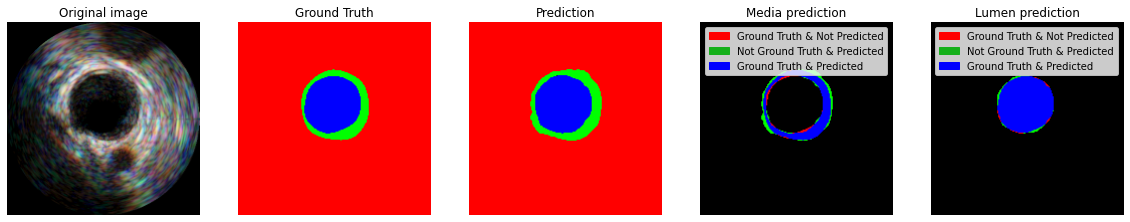

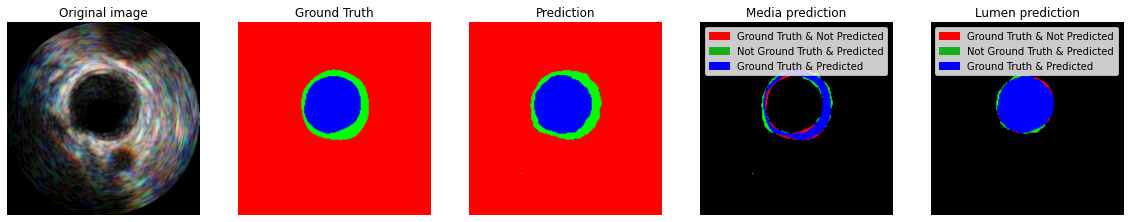

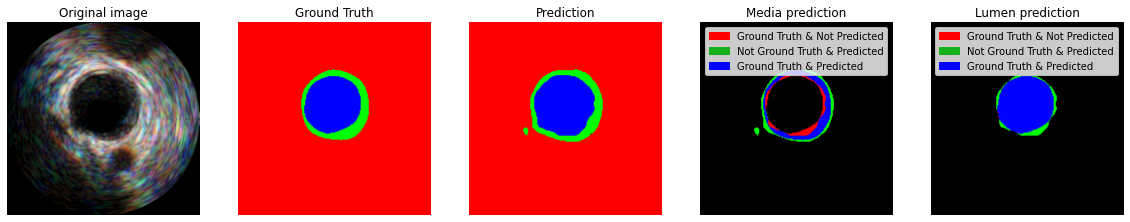

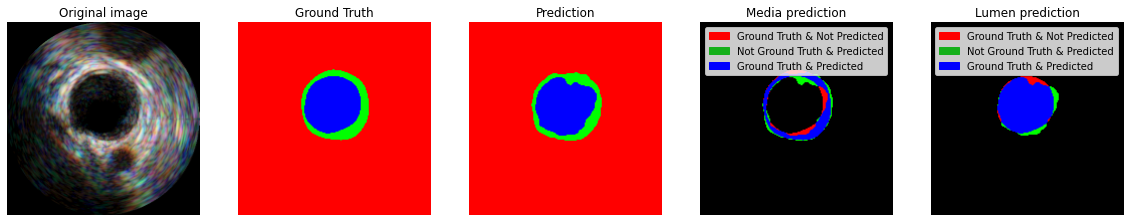

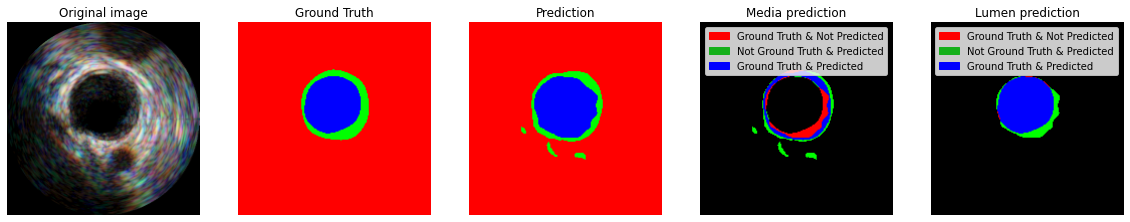

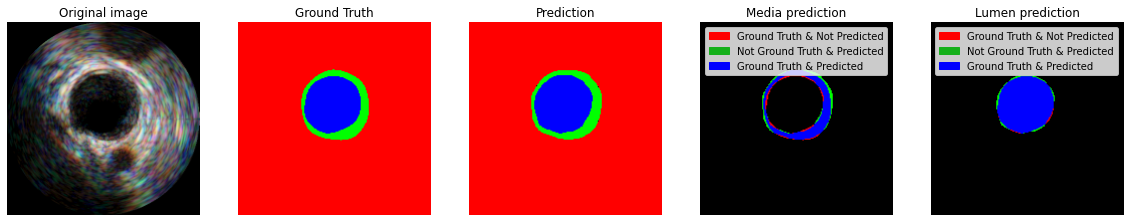

In [39]:
# Show some predictions from the training dataset

samples = 1

img = images_by_pacient[9]
msks = masks_by_pacient[9]

random_num = random.randint(0, len(img)-1)

test_images = img[random_num:random_num+1]
test_masks = msks[random_num:random_num+1]

tf.keras.backend.clear_session()

best_model = build_inception_resnetv2_unet(input_shape)

best_model.load_weights(f"modelF_fold4")

best_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)
test_predictions = best_model.predict(test_images)
print_predictions(test_images[0], test_masks[0], get_mask_from_prediction(test_predictions[0]))

for i in range(5):
    tf.keras.backend.clear_session()

    best_model = build_inception_resnetv2_unet(input_shape)

    best_model.load_weights(f"modelF_fold_p{2*i}_p{2*i+1}")

    best_model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    test_predictions = best_model.predict(test_images)
    print_predictions(test_images[0], test_masks[0], get_mask_from_prediction(test_predictions[0]))